# <p style="text-align: center;">Exploring Manifolds with Flow Models</p>

![Image](https://github.com/TimHenry1995/gyoza/blob/develop/docs/images/Manifold%20Disentanglement.png?raw=true)

### Introduction
In this work, manifolds in the two dimensional plane are explored with flow models. The goal is to disentangle the factors underlying the shape of the manifolds. As the manifolds themselves are one-dimensional objects, there will be one factor for the position along the manifold and another factor for the deviation from the manifold in the form of noise. The model responsible for this disentanglement shall be flexible to capture complicated patterns in the point cloud. It shall also be invertible such that walking along the manifold in disentangled space can be translated back to walking along the manifold in the original space. The family of flow models is selected here.
 
### Approach
Throughout this interactive notebook, several case studies will be conducted to investigate the suitability of flow models for manifold disentanglement in the two dimensional plane. The case studies are constructed to test particular abilities of the model, including rotation, non-linear stretching and discontinuities. In every case study, data will be generated and a model will be calibrated. The results are evaluated quantitatvely and discussed. The reader is encouraged to change experimental configurations where indicated by code comments to verify the observations made throughout this notebook.

### Notation
The overall objective in each case study will be to develop an invertible model $T$ that maps from a point-cloud $Z$ in an arbitrary $\mathbb{R}^2$ space to a disentangled point-cloud $\tilde{Z}$ in $\mathbb{R}^2$. The below table collects all terms that carry special meaning here.

| Term | Definition | 
| --- | --- |
| $M \in \mathbb{N}, m \in \mathbb{N} < M$ | The number of instances $M$ with index $m$ that are shown to the model $T$ for calibration and evaluation. | 
| $F \in \mathbb{N}, k \in \mathbb{N} < F$ | The number of factors F with index $k$. By convention, $k=0$ is chosen as residual factor. Here, $k=1$ is chosen to represent the position along the manifold (see $s$). Here, $F$ is thus chosen to be $2$. |
| $s \in \mathbb{R}, S \in \mathbb{R}^{M,1}$ | The position s along the manifold used to supervise the model $T$ to associate an input $z$ with an output $s$ along factor $k=1$. It is collected with other positions in $S$. |
| $N \in \mathbb{N}, n \in \{0,1,...,N-1\}$ | The dimensionality of $z$ and $\tilde{z}$, here chosen to be $2$. |
| $z \in \mathbb{R}^N, Z \in \mathbb{R}^{M \times N}$ | An instance $z$ of the input space, collected with other instances in point cloud $Z$. |
| $y \in \mathbb{R}^F, Y \in \mathbb{R}^{M \times F} $| The target for each factor, i.e. class labels in the categorical case or scores in the continuous case as used here (see $s$). | 
| $\tilde{z} = T(z), z = T^{-1}(\tilde{z}) \in \mathbb{R}^{N} \mapsto \mathbb{R}^{N}$ | A transformation $T$ (and its inverse $T^{-1}$) that disentangles $Z$ into $F$ factors, each having their dimensionality $N_k$, such that $\sum_{k=0}^{K-1} N_k = N$. |
| $\tilde{z} \in \mathbb{R}^N, \tilde{z}_k \in \mathbb{R}^{N_k}, \tilde{Z} \in \mathbb{R}^{M \times N}$ | The disentangled representation of point cloud $Z$ with factor $k=0$ along the first dimension of $N$ and $k=1$ along the second dimension of N. |
| $z_{ab} \in \mathbb{R}^{2 \times N}, Z_{ab} \in \mathbb{R}^{M \times 2 \times N}$ | A pair of instances $z$, called z_{ab}, where the axis with $2$ entries is the pair axis. It is collected along with other pairs in $Z_{ab}$ and provided to model $T$ during calibration. |
| $y_{ab} \in [0,1]^{F}, Y_{ab} \in \mathbb{R}^{M \times F}$ | The similarity of a pair of instances (see $z_{ab}$) provided in the range from 0 to 1 (inclusive) for each factor . It is collected along with other similarities in $Y_{ab}$ and used to supervise model $T$ during calibration. Note: For the residual factor the similarity is usually not known and here set to 0. |

Naming conventions:
- Lowercase letters are used to denote indices (e.g. $n,m$), scalars (e.g. $s$) or vectors (e.g. $z, \tilde{z}$).
- Uppercase letters are used to denote totals (e.g. $N,M$) or collections of instances (e.g. $Z, \tilde{Z}, S$).


# Preparations

### Package Management

In [ ]:
!pip install ipywidgets

In [1]:
# Import modules
import importlib
import tensorflow as tf, random, os, matplotlib.pyplot as plt, numpy as np
from gyoza.modelling import flow_layers as mfl, masks as gmm, standard_layers as msl, data_iterators as mdis
from gyoza.utilities import math as gum
from typing import List, Callable, Tuple
from ipywidgets import interact, fixed
plt.rcParams["font.family"] = "Times New Roman";

2023-07-27 10:08:20.598064: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Reload custom modules
importlib.reload(mfl)
importlib.reload(gmm)
importlib.reload(msl)
importlib.reload(mdis)
importlib.reload(gum);

### Data Synthesis

In [2]:
# For reproducability
def reset_random_number_generators(seed: int):
    """This function resets the random number generators of python, numpy and tensorflow.

    :param seed: The new seed that shall be provided to each random number generator.
    :type seed: int
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    
def create_data_set(S: np.array, manifold_function: Callable, noise_strength: float) -> Tuple[np.array, np.array]:
    """Creates a data set by passing the position ``S`` along the manifold through the ``manifold_function`` and adding Gaussian noise to 
    each dimension. That noise is centered at zero and has standard devitation ``noise_strength``.

    :param S: The position along the manifold. Shape == [:math:`M`, 1], where :math:`M` is the number of instances
    :type S: np.array
    :param manifold_function: A function that maps from ``S`` to coordinates on the manifold in the real two dimensional plane.
    :type manifold_function: :class:`Callable`
    :param noise_strength: Standard deviation of the noise.
    :type noise_strength: float
    :return: 
        - Z (:class:`numpy.ndarray`) - The collection of points around the manifold. Shape == [:math:`M`, :math:`N`], where :math:`M` is the 
            instance count and :math:`N` the dimensionality.
        - Y (:class:`numpy.ndarray`) - The target for factorization. Here, it is 0 for the residual factor (index 0) and S for the position factor
            (index 1). Shape == [:math:`M`, :math:`F`], where :math:`M` is the instance count and :math:`F=2` the factor count.
    """
    
    # Add noise 
    data_function = lambda x: add_noise(*manifold_function(x), noise_strength=noise_strength)

    # Generate data
    Y = np.concatenate([np.zeros([len(S),1]), S[:, np.newaxis]], axis=1) # Dimension at index 0 is residual factor, at index 1 is position along manifold
    Z_1, Z_2 = data_function(S) # Map line s onto manifold in 2D plane
    Z = np.concatenate([Z_1[:,np.newaxis], Z_2[:,np.newaxis]], axis=1)

    # Outputs
    return Z, Y


# Adds noise to data points on the manifold
add_noise = lambda x_1, x_2, noise_strength: (x_1 + noise_strength * np.random.normal(scale=noise_strength, size=x_1.shape), x_2 + noise_strength * np.random.standard_normal(size=x_2.shape))

# Generate equally spaced points along a line
M = 1024; N = 2
golden_ratio = (1 + 5 ** 0.5) / 2
beta = np.log(golden_ratio)/(np.pi/2) # https://en.wikipedia.org/wiki/Golden_spiral see section on mathematics
s_max = (1*np.sqrt(1+beta**2)/beta)*(np.exp(beta*2*np.pi)-1)/2 # https://www.quora.com/What-is-the-arc-length-of-the-logarithmic-spiral-from-t0-to-t the arc length of the golden spiral for one full rotation
S = np.linspace(-s_max,s_max,M, dtype=tf.keras.backend.floatx()) # These points are the steps along any manifold
S_star = np.linspace(np.min(S), np.max(S), 100) # Take a small set of points to plot manifold efficiently

# This function computes the similarity Y_ab
similarity_function = lambda Y_a, Y_b: np.concatenate([np.zeros([Y_a.shape[0],1]), 1 - np.abs(Y_a[:,1:2]-Y_b[:,1:2])/ (np.abs(np.max(S)-np.min(S)))], axis=1);

### Plotting

In [3]:
def plot_instance_pairs(S: np.ndarray, Z_ab: np.ndarray, Y_ab: np.ndarray, manifold_function: Callable, manifold_name: str):
    """Plots pairs of instances along with their similarities and the manifold (without noise).

    :param S: The position along the manifold. Shape == [:math:`M`, 1], where :math:`M` is the number of instances.
    :type S: np.array
    :param Z_ab: The coordinates of the instances to be plotted. Shape is assumed to be [:math:`M`, 2, :math:`N`], where :math:`M` is the number
        of instances, the 2 at axis 1 enumerates the two instances of the pair and :math:`N = 2` is the dimensionality of an instance.
    :type Z_ab: :class:`numpy.ndarray`
    :param Y_ab: The similarities of the ``Z_ab`` instances. Shape is assumed to be [:math:`M`, :math:`F`], where :math:`M` is the number of 
        instances and :math:`F=2` at axis 1 is the factor count.
    :type Y_ab: :class:`numpy.ndarray`
    :param manifold_function: A function that takes as input the position ``S`` along the manifold and provides as output the two coordinates
        that are associated with that position along the manifold. Hence, [:math:`M`,1] -> [:math:`M`, :math:`N`], where M is the number of 
        instances and :math:`N=2` their dimensionality
    :type manifold_function: Callable
    :param manifold_name: A name assigned to the manifold that is used as a label in the plot.
    :type manifold_name: str
    """

    # Construct figure
    plt.figure(figsize=(3.5,3.5)); plt.title(rf"Instance Pairs And Similarities on ${manifold_name}$")
        
    # Plot instance pairs
    plt.scatter(Z_ab[:,0,0], Z_ab[:,0,1]) # Instances a
    plt.scatter(Z_ab[:,1,0], Z_ab[:,1,1]) # Instances b

    # Plot manifold
    plt.scatter(*manifold_function(S), color='gray', marker='.', s=1)

    # Label current plots
    plt.legend(['z_a','z_b'])

    # Plot lines that connect the two instances of a pair
    s_max = np.max(S)
    for i in range(Z_ab.shape[0]): # Iterate instances
        plt.plot([Z_ab[i,0,0], Z_ab[i,1,0]], [Z_ab[i,0,1], Z_ab[i,1,1]], '--', color='black')
        plt.text(Z_ab[i,1,0]+0.5, Z_ab[i,1,1], 's = ' + str(np.round(Y_ab[i,1], 2))) # Label for their similarity
    plt.ylim(-s_max/0.8,s_max/0.8); plt.xlim(-s_max/0.8,s_max/0.8)
    
    plt.xlabel('First Dimension'); plt.ylabel('Second Dimension')
    plt.show()

def plot_loss_trajectory(epoch_loss_means: List[float], epoch_loss_standard_deviations: List[float], manifold_name: str):
    """Plots the loss trajectory after model calibration with error surface.

    :param epoch_loss_means: The mean across batches for each epoch. Length = [epoch count]
    :type epoch_loss_means: List[float]
    :param epoch_loss_standard_deviations:  The standard deviation across batches for each epoch. Length = [epoch count]
    :type epoch_loss_standard_deviations: List[float]
    :param manifold_name: The name of the manifold on which the model was calibrated. Used for the title.
    :type manifold_name: str
    """

    # Preprocess
    M = len(epoch_loss_means)
    means = np.array(epoch_loss_means)
    errors = 2.0 * np.array(epoch_loss_standard_deviations) / np.sqrt(M)

    # Create figure
    plt.figure(figsize=[12,3]); plt.title(rf'Loss Trajectory on Manifold ${manifold_name}$')

    # Error surface
    plt.fill_between(x=list(range(M)), y1=means-errors, y2=means+errors, color='mistyrose')

    # Line
    plt.plot(epoch_loss_means)

    # Labels
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend([r'$\pm 2*$ Standard Error', 'Mean Across Batches'])

def plot_input_output(network: mfl.SupervisedFactorNetwork, S_range: Tuple[float,float], manifold_function: Callable, noise_strength: float, manifold_name: str):
    """Plots the input and output to the ``network``. Points are colored using a color wheel. Supplementary marginal distribution are provided.

    :param network: The network that shall process the data. It is expected to map from [:math:`M`,:math:`N`] to [:math:`M`,:math:`N`], where
        :math:`M` is the instance count and :math:`N=2` the dimensionality. 
    :type network: mfl.SupervisedFactorNetwork
    :param S_range: The range of position along the manifold. The first entry is assumed to be the minimum while the second entry is assumed to
        be the maximum.
    :type S_range: Tuple[float,float]
    :param manifold_function: A function that maps from position on manifold (:math:`S`, shape == [instane count M]) to coordinates in :math:`N=2`
        dimensional space.
    :type manifold_function: Callable
    :param noise_strength: Standard deviation of the noise that shall be added to the data before passing it through the model.
    :type noise_strength: float
    :param manifold_name: The name of the manifold used in the title.
    :type manifold_name: str
    """

    # Sample from manifold to illustrate distortion of data
    S = np.linspace(S_range[0], S_range[1], len(gum.color_palette)) # Each point will receive its own color
    x_1, x_2 = add_noise(*manifold_function(S), noise_strength=noise_strength)
    
    # Create gridlines to illustrate distortion of surrounding space
    points_per_line = 10
    min_x_1 = np.min(x_1); max_x_1 = np.max(x_1); mean_x_1 = np.abs(np.mean(x_1)) # Horizontal ticks
    min_x_2 = np.min(x_2); max_x_2 = np.max(x_2); mean_x_2 = np.abs(np.mean(x_2)) # Vertical ticks

    if (np.abs(max_x_1 - min_x_1) < np.abs(max_x_2 - min_x_2)): # Ensures lines are large enough to encompass data and square
        x_2_grid = np.linspace(min_x_2 - np.abs(mean_x_2 - min_x_2), max_x_2 + np.abs(mean_x_2-max_x_2), points_per_line)
        h_x_1, h_x_2 = np.meshgrid(x_2_grid, x_2_grid) # horizontal line coordinates
        v_x_2, v_x_1 = np.meshgrid(x_2_grid, x_2_grid) # vertical line coordinates
    else:
        x_1_grid = np.linspace(min_x_1 - np.abs(mean_x_1-min_x_1), max_x_1 + np.abs(mean_x_1-max_x_1), points_per_line)
        h_x_1, h_x_2 = np.meshgrid(x_1_grid, x_1_grid) # horizontal line coordinates
        v_x_2, v_x_1 = np.meshgrid(x_1_grid, x_1_grid) # vertical line coordinates

    # Plot
    fig, axs = plt.subplots(2,4,figsize=(9,4.5), gridspec_kw={'height_ratios': [4, 0.5], 'width_ratios':[0.5,4,0.5,4]})
    
    # 1. Plot joint distributions
    # 1.1 Z
    plt.suptitle(rf"Inference on ${manifold_name}$")
    plt.subplot(2,4,2); plt.title("Input")
    
    # 1.1.1 Gridlines
    for l in range(points_per_line): plt.plot(h_x_1[l,:], h_x_2[l,:], color='#C5C9C7', linewidth=0.75)
    for l in range(points_per_line): plt.plot(v_x_1[l,:], v_x_2[l,:], color='#C5C9C7', linewidth=0.75)
    
    # 1.1.2 Data
    Z = np.concatenate([x_1[:,np.newaxis], x_2[:, np.newaxis]], axis=1)
    plt.scatter(Z[:,0], Z[:,1], c=gum.color_palette/255.0, zorder=3); plt.xlabel("First Dimension"); plt.ylabel("Second Dimension")
    Z_x_lim = plt.gca().get_xlim(); Z_y_lim = plt.gca().get_ylim() # Use these for marginal distributions
    
    # 1.2 Z tilde
    plt.subplot(2,4,4); plt.title("Output")
    Z_tilde = network(Z)
    H_Z_tilde = network(tf.concat([np.reshape(h_x_1, [-1])[:,np.newaxis], np.reshape(h_x_2, [-1])[:,np.newaxis]], axis=1))
    V_Z_tilde = network(tf.concat([np.reshape(v_x_1, [-1])[:,np.newaxis], np.reshape(v_x_2, [-1])[:,np.newaxis]], axis=1))
    
    # 1.2.1 Gridlines
    for l in range(points_per_line): plt.plot(H_Z_tilde[l*points_per_line:(l+1)*points_per_line,0], H_Z_tilde[l*points_per_line:(l+1)*points_per_line,1], color='#C5C9C7', linewidth=0.75)
    for l in range(points_per_line): plt.plot(V_Z_tilde[l*points_per_line:(l+1)*points_per_line,0], V_Z_tilde[l*points_per_line:(l+1)*points_per_line,1], color='#C5C9C7', linewidth=0.75)
    
    # 1.2.2 Data
    plt.scatter(Z_tilde[:,0], Z_tilde[:,1], c=gum.color_palette/255.0, zorder=3); plt.xlabel('Residual Factor'); plt.ylabel('Manifold Position Factor')
    Z_tilde_min = np.min(Z_tilde, axis=0); Z_tilde_max = np.max(Z_tilde, axis=0); Z_tilde_mean = np.mean(Z_tilde, axis=0)
    Z_tilde_x_lim = (Z_tilde_min[0] - np.abs(Z_tilde_mean[0] - Z_tilde_min[0]), Z_tilde_max[0] + np.abs(Z_tilde_mean[0] - Z_tilde_max[0])); 
    Z_tilde_y_lim = (Z_tilde_min[1] - np.abs(Z_tilde_mean[1] - Z_tilde_min[1]), Z_tilde_max[1] + np.abs(Z_tilde_mean[1] - Z_tilde_max[1])); 
    plt.xlim(*Z_tilde_x_lim); plt.ylim(*Z_tilde_y_lim)
    
    # 2. Plot marginal distributions
    # 2.1 Z
    plt.subplot(2,4,6)
    plt.hist(Z[:,0], histtype='step'); plt.xlim(Z_x_lim); plt.gca().invert_yaxis(); plt.axis('off')
    plt.subplot(2,4,1)
    plt.hist(Z[:,1], orientation='horizontal', histtype='step'); plt.ylim(Z_y_lim); plt.gca().invert_xaxis(); plt.axis('off')
    
    # 2.2 Z tilde
    plt.subplot(2,4,8)
    plt.hist(Z_tilde[:,0], histtype='step'); plt.gca().invert_yaxis(); plt.xlim(Z_tilde_x_lim); plt.axis('off')
    plt.subplot(2,4,3)
    plt.hist(Z_tilde[:,1], orientation='horizontal', histtype='step'); plt.ylim(Z_tilde_y_lim); plt.gca().invert_xaxis(); plt.axis('off')
    
    # Make other subplots invisible
    plt.subplot(2,4,5); plt.axis('off')
    plt.subplot(2,4,7); plt.axis('off')

    plt.tight_layout()
    plt.show() 

def evaluate_and_plot_networks(Z_test: List[np.ndarray], Y_test: List[np.ndarray], networks: List[mfl.SupervisedFactorNetwork], manifold_name: str):
    """For each network, a scatter plot for the predicted and actual position along the manifold is plotted along with a bar for the proportion
    of explained variance. 

    :param Z_test: A list of test sets used as input to the corresponding network in ``networks``. The list is expected to have the same length
        as ``networks`` and each test set is assumed to have shape [:math:`M^*`,:math:`N`], where :math:`M^*` is the number of instances in a 
        test set and :math:`N=2` is the dimensinoality of an instance.
    :type Z_test: List[np.ndarray]
    :param Y_test: A list of test sets used to evaluate to the corresponding network in ``netwroks``. The list is expected to have the same length
        as ``networks`` and each test set is assumed to have shape [:math:`M^*`,:math:`F`], where :math:`M^*` is the number of instances in a 
        test set and :math:`F=2` is the number of factors. It is assumed that factor at index 1 encodes the position along the manifold.
    :type Y_test: List[np.ndarray]
    :param networks: A list of calibrated networks that take ``Z_test`` as input and whose output (of same shape as input) encodes position along
        the data manifold along index 2.
    :type networks: List[mfl.SupervisedFactorNetwork]
    :param manifold_name: The name of the manifold used in the figure title.
    :type manifold_name: str
    """

    # Prepare figure
    fold_count = len(networks)
    fig, axs = plt.subplots(1,3*fold_count,figsize=(12,2), gridspec_kw={'width_ratios': [6, 1, 1]*fold_count})
    plt.suptitle(rf"{fold_count}-Fold Cross Validated Evaluation on ${manifold_name}$")

    # Iterate networks
    for n, network in enumerate(networks):
        # 1. Predict
        Y_hat = network(Z_test[n]).numpy()
        Y = Y_test[n]

        # 2. Create scatter plot for manifold position
        plt.subplot(1,3*fold_count, 3*n+1); 
        plt.scatter(Y_hat[:,1], Y[:,1], color='black', marker='.', s=1); 
        ax = plt.gca();ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        
        if n == 0:  
            plt.ylabel("Manifold Position\n\nActual"); plt.xlabel("Predicted")
        else:
            plt.yticks([]); plt.xlabel(f'Fold {n+1}')
        
        # 3. Create bar plot for proportion of explained variance for position along manifold (factor at position 1)
        r2 = np.corrcoef(Y[:,1], Y_hat[:,1])[1,0]**2 # Since the output is a correlation matrix, the [1,0] selects the correlation between the two variables
        
        plt.subplot(1,3*fold_count, 3*n+2); 
        plt.bar([0], [r2], color='white', edgecolor='black'); plt.ylim([0,1]); plt.xlim([-1,1]); plt.xticks([])#[n+1], [f"Fold {n+1}"])
        if n==0:
            ax = plt.gca();ax.spines['top'].set_visible(False); ax.spines['left'].set_visible(False); ax.spines['right'].set_visible(False)
            plt.ylabel(r'$r^2$');  plt.gca().yaxis.tick_right();  plt.yticks([0,1])
        else:plt.axis('off')

        t=plt.text(-0,r2/2,f'{np.round(r2,2)}', horizontalalignment='center'); t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='white'))
        
        # Padding on right of each bar plot
        plt.subplot(1,3*fold_count, 3*n+3); plt.axis('off')

    plt.show()

def plot_inverse_point(position: float, residual: float, S: np.ndarray, network: mfl.SupervisedFactorNetwork, manifold_function: Callable, manifold_name: str):
    """This function visualizes the ``network``'s inversion ability by plotting the inverse of the point[``residual``, ``position``]. It also 
    plots the ``manifold_function`` on input ``S`` for reference.

    :param position: The position along the manifold that shall be entered for dimensions at index 1 for inversion via the ``network``.
    :type position: float
    :param residual: The residual that shall be entered for dimensions at index 0 for inversion via the ``network``.
    :type residual: float
    :param S: Points along which the ``manifold_function`` shall be evaluated during plotting.
    :type S: :class:`numpy.ndarray`
    :param network: A network calibrated to disentangle manifold position (factor at dimension 1) from deviation from manifold (factor at 
        dimension 0). It shall map from [:math:`M`,:math:`N`] to [:math:`M`,:math:`N`], where :math:`M` is the instance count and :math:`N=2`
        is the dimensionality.
    :type network: mfl.SupervisedFactorNetwork
    :param manifold_function: A function that maps from position on manifold (:math:`S`, shape == [instane count M]) to coordinates in :math:`N=2`
        dimensional space.
    :type manifold_function: _type_
    :param manifold_name: The name of the manifold used for the figure title.
    :type manifold_name: str
    """
    
    # Construct figure
    plt.figure(figsize=(3.5,3.5)); plt.title(rf"Inverse Modelling on ${manifold_name}$")
        
    # Predict position using network
    Z_tilde = np.array([[residual,position]], dtype=tf.keras.backend.floatx())
    Z = network.invert(Z_tilde)
    plt.scatter(Z[:,0], Z[:,1])

    # Plot manifold
    plt.scatter(*manifold_function(S), color='gray', marker='.', s=1)

    # Axes and labels
    s_max = np.max(S)
    plt.ylim(-s_max/0.8,s_max/0.8); plt.xlim(-s_max/0.8,s_max/0.8)
    plt.xlabel('First Dimension'); plt.ylabel('Second Dimension')
    plt.show()

### Model

In [112]:
def create_network(Z_sample: np.ndarray, stage_count: int) -> mfl.SupervisedFactorNetwork:
    """This function creates a supervised factor network that has starts with an activation normalization layer and then has ``stage_count`` many 
    consecutive processing stages. Each stage consists of a reflection layer, followed by an full coupling layer (one coupling layer with 
    positive Heaviside mask, one with nagative) and an activation normalization layer. During inference, the network takes input :math:`Z` and 
    outputs :math:'\tilde{Z}' which each have shape [:math:`M`, :math:`N`], where :math:`M` is the instance count and :math:`N=2` is the 
    dimensionality.

    :param Z_sample: A representative sample of the data to be fed through the model. This is needed to initialize some layer parameters. Shape
        is assumed to be [sample size, :math:`N`], where :math:`N=2` is the dimensionality of an instance.
    :type Z_sample: :class:`numpy.ndarray`
    :param stage_count: The number of processing stages that the ``network`` shall use. 
    :type stage_count: int 
    :return: network (:class:`SupervisedFactorNetwork`) - The network.
    """

    # Set up the coupling functions and masks for the coupling layers
    dimensionality = 2
    layers = [None] * (1+6*stage_count)
    layers[0] = mfl.ActivationNormalization(axes=[1], shape=[dimensionality])
    for i in range(stage_count):
        layers[6*i+1] = mfl.Reflection(axes=[1], shape=[dimensionality], reflection_count=2)
        
        compute_coupling_parameters_1 = msl.BasicFullyConnectedNet(latent_dimension_count=4*dimensionality, output_dimension_count=dimensionality, depth=3)
        mask_1 = gmm.CheckerBoard(axes=[1], shape=[dimensionality])
        
        layers[6*i+2] = mfl.AdditiveCoupling(axes=[1], shape=[dimensionality], compute_coupling_parameters=compute_coupling_parameters_1, mask=mask_1) 
        layers[6*i+3] = mfl.Heaviside(axes=[1], shape=[dimensionality])
        
        compute_coupling_parameters_2 = msl.BasicFullyConnectedNet(latent_dimension_count=4*dimensionality, output_dimension_count=dimensionality, depth=3)
        mask_2 = gmm.CheckerBoard(axes=[1], shape=[dimensionality])
    
        layers[6*i+4] = mfl.AdditiveCoupling(axes=[1], shape=[dimensionality], compute_coupling_parameters=compute_coupling_parameters_2, mask=mask_2) 
        layers[6*i+5] = mfl.Heaviside(axes=[1], shape=[dimensionality])
        
        layers[6*i+6] = mfl.ActivationNormalization(axes=[1], shape=[dimensionality])
        
    # Construct the network
    network = mfl.SupervisedFactorNetwork(sequence=layers, dimensions_per_factor=[1,1]) # One dimension for the residual factor (index 0) and one for the manifold proximity (index 1)
    network(Z_sample) # Initialization of some layer parameters
    
    # Outputs
    return network

def cross_validate(Z: np.ndarray, Y: np.ndarray, networks: List[mfl.SupervisedFactorNetwork], batch_size: int, epoch_count: int, similarity_function: Callable, manifold_name: str) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """Performs cross-validation on the provided networks. It first shuffles the data ``Z`` and ``Y``, then partitions it into fold-count many
    equally sized subsets and then calibrates each network on the data set-minus one subset of the partition. The held out subsets are returned
    for model evaluationl. The fold-count is inferred from the length of ``network``. This implementation assumes that the networks are 
    :class:`SupervisedFactorNetworks` that are calibrated using the :py:func:`volatile_factorized_pair_iterator`.

    :param Z: The input to the networks (when in inference mode) of shape [:math:`M`,:math:`N`], where :math:`M` is the total instance count and 
        :math:`N` the dimensionality.
    :type Z: :class:`numpy.ndarray`
    :param Y: The factorized targets per instance of shape [:math:`M`. :math:`F`], where :math:`M` is the total instance count and :math:`F` is 
        the factor count.
    :type Y: :class:`numpy.ndarray`
    :param networks: The networks to be calibrated. They are assumed to be compiled with an optimizer.
    :type networks: List[:class:`SupervisedFactorNetwork`]
    :param batch_size: The size of batches used during calibration.
    :type batch_size: int
    :param epoch_count: The number of times the iterator shall cycle through the data during calibration of each network.
    :type epoch_count: int
    :param similarity_function: A function that takes maps from Y_a (shape == [:math:`M`,:math:`F`]), Y_b (shape == [:math:`M`,:math:`F`]) to 
        [:math:`M`,:math:`F`] to indicate the similarity of an instance a to an instance b along each factor. :math:`M` is the number of instances
        and :math:`F` the number of factors.
    :type similarity_function: Callable
    :param manifold_name: The name of the manifold on which the networks are fitted. Used for the title of the plot.
    :type manifold_name: str
    :return: 
        - Z_test (List[:class:`numpy.ndarray`]) - The test subsets for the model input, one for each instance in ``networks``, having 
            shape [:math:`M^*`,:math:`N`], where :math:`M^*` is the test set size equal to the total instance count in ``Z`` divided by the 
            number of instances in ``networks`` and :math:`N` is the dimensionality.
        - Y_test (List[:class:`numpy.ndarray`]) - The test subsets for the models factor targets, one for each instance in ``networks``, having 
            shape [:math:`M^*`,:math:`F`], where :math:`M^*` is the test set size equal to the total instance count in ``Z`` divided by the 
            number of instances in ``networks`` and :math:`F` is the number of factors.
    """

    # Shuffle indices
    M = Z.shape[0]
    indices = list(range(M)); random.shuffle(indices)

    # Prepare figure
    fold_count = len(networks)
    
    # Cross validate
    Z_test = [None] * fold_count; Y_test = [None] * fold_count
    fold_size = M // fold_count
    for k in range(fold_count): 
        
        # Calibrate
        train_indices = indices[:(k-1)*fold_size] + indices[(k+1)*fold_size:]
        M = len(train_indices)
        iterator = mdis.volatile_factorized_pair_iterator(X=Z[train_indices,:], Y=Y[train_indices,:], batch_size=batch_size, similarity_function=similarity_function)
        epoch_loss_means, _ = networks[k].fit(iterator=iterator, epoch_count=epoch_count, batch_count=M//batch_size)
        
        # Save test indices
        test_indices = indices[k*fold_size:(k+1)*fold_size]
        Z_test[k] = Z[test_indices,:]; Y_test[k] = Y[test_indices,:]

    # Outputs
    return Z_test, Y_test

# Case Study 1: Rotation

### Data Synthesis

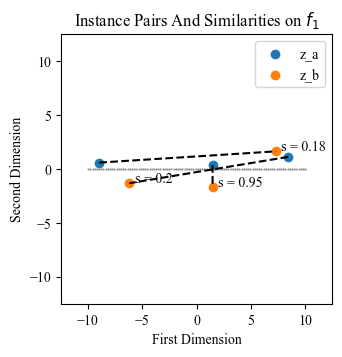

In [182]:
manifold_name = 'f_1'

# Set up the raw manifold function
manifold_function = lambda S: gum.rotate(xs=S, ys=0*S, theta=0) 

# Generate a dataset
reset_random_number_generators(seed=63) # Reproducability
noise_strength = 1.0
Z, Y = create_data_set(S=S, manifold_function=manifold_function, noise_strength=noise_strength) # Z.shape == [M, N], Y.shape = [M, F]

# Plot pairs of instances
iterator = mdis.volatile_factorized_pair_iterator(X=Z, Y=Y, batch_size=32, similarity_function=similarity_function)
Z_ab, Y_ab = next(iterator)

plot_instance_pairs(S=S_star, Z_ab=Z_ab[:3,:,:], Y_ab=Y_ab[:3,:], manifold_function=manifold_function, manifold_name=manifold_name)

### Model Calibration

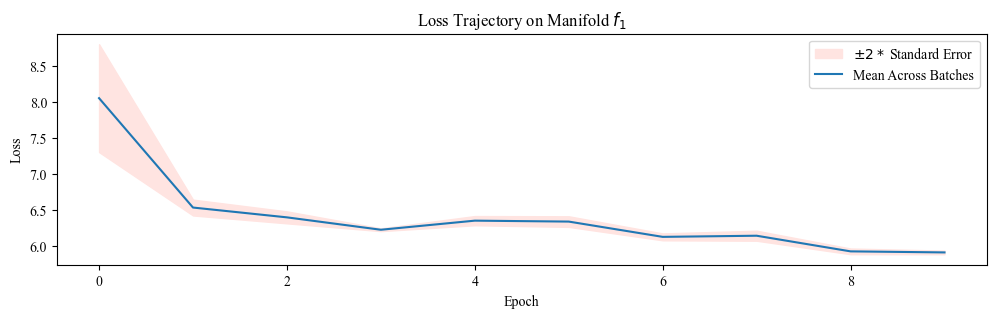

In [183]:
# Create network
reset_random_number_generators(seed=247) # Reproducability
network = create_network(Z_sample=Z[np.random.choice(M, size=128)], stage_count=1)
network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05))

# Calibrate network
batch_size = 256
iterator = mdis.volatile_factorized_pair_iterator(X=Z, Y=Y, batch_size=batch_size, similarity_function=similarity_function)
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=10, batch_count=M//batch_size)
plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

In [184]:
# Cross validate model behaviour
reset_random_number_generators(seed=620) # Reproducability
networks = [None] * 5 # Fold-count many networks
for i in range(len(networks)):
    networks[i] = create_network(Z_sample=Z[np.random.choice(M, size=128)], stage_count=1)
    networks[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05))
Z_test, Y_test = cross_validate(Z=Z, Y=Y, networks=networks, batch_size=256, epoch_count=10, similarity_function=similarity_function, manifold_name=manifold_name)

### Evaluation

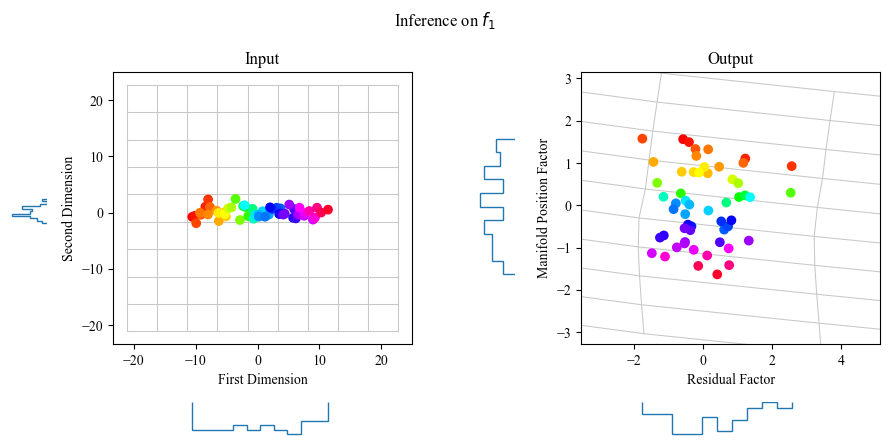

interactive(children=(FloatSlider(value=0.0, description='position', max=1.5, min=-1.5), FloatSlider(value=0.0…

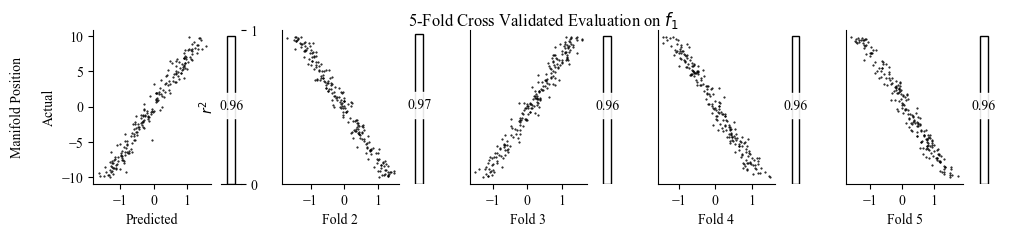

In [185]:
# Plot input and output
plot_input_output(network, S_range = [np.min(S), np.max(S)], manifold_function=manifold_function, noise_strength=noise_strength, manifold_name=manifold_name)

# Plot interactive tool
interact(plot_inverse_point, position=(-1.5,1.5,0.1), residual=(-1.5,1.5,0.1), S=fixed(S_star), network=fixed(network), manifold_function=fixed(manifold_function), manifold_name=fixed(manifold_name))

# Plot cross validation
evaluate_and_plot_networks(Z_test=Z_test, Y_test=Y_test, networks=networks, manifold_name=manifold_name)

# Case Study 2: Twist

### Data Synthesis

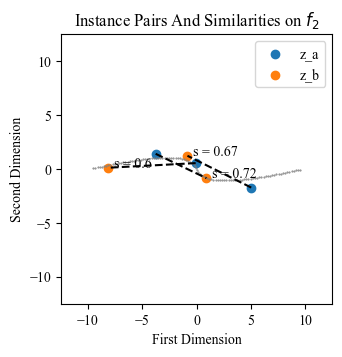

In [162]:
# Set up the raw manifold function
manifold_name = 'f_2'
manifold_function = lambda S: gum.rotate(xs=np.arcsinh(S), ys=np.sign(np.arcsinh(S)) * np.cosh(np.arcsinh(S)) - np.sign(S), theta=1.2*np.pi/2.0) 

# Generate a dataset
reset_random_number_generators(seed=503) # Reproducability
noise_strength = 0.3
Z, Y = create_data_set(S=S, manifold_function=manifold_function, noise_strength=noise_strength) # Z.shape == [M, N], Y.shape = [M, F]

# Plot pairs of instances
iterator = mdis.volatile_factorized_pair_iterator(X=Z, Y=Y, batch_size=32, similarity_function=similarity_function)
Z_ab, Y_ab = next(iterator)

plot_instance_pairs(S=S_star, Z_ab=Z_ab[:3,:,:], Y_ab=Y_ab[:3,:], manifold_function=manifold_function, manifold_name=manifold_name)

### Model Calibration

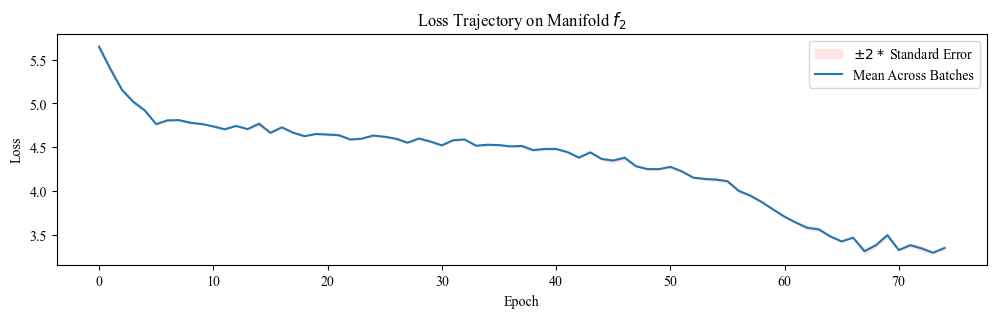

In [165]:
# Create network
reset_random_number_generators(seed=227) # Reproducability
network = create_network(Z_sample=Z[np.random.choice(M, size=128)], stage_count=3)
network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

# Calibrate network
batch_size = 512
iterator = mdis.volatile_factorized_pair_iterator(X=Z, Y=Y, batch_size=batch_size, similarity_function=similarity_function)
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=75, batch_count=M//batch_size)
plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

In [ ]:
# Cross validate model behaviour
reset_random_number_generators(seed=620) # Reproducability
networks = [None] * 5 # Fold-count many networks
for i in range(len(networks)):
    networks[i] = create_network(Z_sample=Z[np.random.choice(M, size=128)], stage_count=3)
    networks[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
Z_test, Y_test = cross_validate(Z=Z, Y=Y, networks=networks, batch_size=512, epoch_count=75, similarity_function=similarity_function, manifold_name=manifold_name)

### Evaluation

In [ ]:
# Plot input and output
plot_input_output(network, S_range = [np.min(S), np.max(S)], manifold_function=manifold_function, noise_strength=noise_strength, manifold_name=manifold_name)

# Plot interactive tool
interact(plot_inverse_point, position=(-1.5,1.5,0.1), residual=(-1.5,1.5,0.1), S=fixed(S_star), network=fixed(network), manifold_function=fixed(manifold_function), manifold_name=fixed(manifold_name))

# Plot cross validation
evaluate_and_plot_networks(Z_test=Z_test, Y_test=Y_test, networks=networks, manifold_name=manifold_name)

# Case Study 3: Overlap

### Data Synthesis

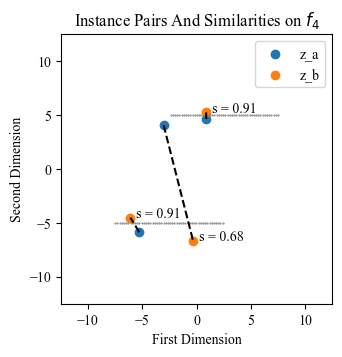

In [177]:
# Set up the raw manifold function
manifold_name = 'f_4'
# Set up the raw manifold function
def manifold_function(S):
    half_1 = S[np.where(S <  0)]
    half_2 = S[np.where(0 <= S)]
    s_max = np.max(S)
    Z_1 = np.concatenate([half_1, half_2 - s_max/2]) + 1*s_max/4
    Z_2 = np.array([1*s_max/2]* len(half_1) + [3*s_max/2] * len(half_2)) - s_max

    return Z_1, Z_2

# Generate a dataset
reset_random_number_generators(seed=256) # Reproducability
noise_strength = 1
Z, Y = create_data_set(S=S, manifold_function=manifold_function, noise_strength=noise_strength) # Z.shape == [M, N], Y.shape = [M, F]

# Plot pairs of instances
iterator = mdis.volatile_factorized_pair_iterator(X=Z, Y=Y, batch_size=32, similarity_function=similarity_function)
Z_ab, Y_ab = next(iterator)

plot_instance_pairs(S=S_star, Z_ab=Z_ab[:3,:,:], Y_ab=Y_ab[:3,:], manifold_function=manifold_function, manifold_name=manifold_name)


### Model Calibration

In [ ]:
# Create network
reset_random_number_generators(seed=272) # Reproducability
network = create_network(Z_sample=Z[np.random.choice(M, size=128)], stage_count=3)
network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))

# Calibrate network
batch_size = 512
iterator = mdis.volatile_factorized_pair_iterator(X=Z, Y=Y, batch_size=batch_size, similarity_function=similarity_function)
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=75, batch_count=M//batch_size)
plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

In [ ]:
# Cross validate model behaviour
reset_random_number_generators(seed=620) # Reproducability
networks = [None] * 5 # Fold-count many networks
for i in range(len(networks)):
    networks[i] = create_network(Z_sample=Z[np.random.choice(M, size=128)], stage_count=3)
    networks[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))
Z_test, Y_test = cross_validate(Z=Z, Y=Y, networks=networks, batch_size=512, epoch_count=75, similarity_function=similarity_function, manifold_name=manifold_name)

### Evaluation

In [ ]:
# Plot input and output
plot_input_output(network, S_range = [np.min(S), np.max(S)], manifold_function=manifold_function, noise_strength=noise_strength, manifold_name=manifold_name)

# Plot interactive tool
interact(plot_inverse_point, position=(-1.5,1.5,0.1), residual=(-1.5,1.5,0.1), S=fixed(S_star), network=fixed(network), manifold_function=fixed(manifold_function), manifold_name=fixed(manifold_name))

# Plot cross validation
evaluate_and_plot_networks(Z_test=Z_test, Y_test=Y_test, networks=networks, manifold_name=manifold_name)

# Case Study 4: Spiral

### Data Synthesis

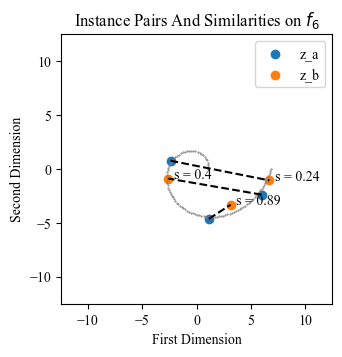

In [180]:
# Set up the raw manifold function
manifold_name = 'f_5'
manifold_function = lambda S: gum.logarithmic_spiral(xs=np.log((S+s_max)/(1*np.sqrt(1+beta**2)/beta)+1)/beta, alpha=1, beta=beta) # https://www.quora.com/What-is-the-arc-length-of-the-logarithmic-spiral-from-t0-to-t

# Generate a dataset
reset_random_number_generators(seed=2) # Reproducability
noise_strength = 0.5
Z, Y = create_data_set(S=S, manifold_function=manifold_function, noise_strength=noise_strength) # Z.shape == [M, N], Y.shape = [M, F]

# Plot pairs of instances
iterator = mdis.volatile_factorized_pair_iterator(X=Z, Y=Y, batch_size=32, similarity_function=similarity_function)
Z_ab, Y_ab = next(iterator)

plot_instance_pairs(S=S_star, Z_ab=Z_ab[:3,:,:], Y_ab=Y_ab[:3,:], manifold_function=manifold_function, manifold_name=manifold_name)

### Model Calibration

In [ ]:
# Create network
reset_random_number_generators(seed=869) # Reproducability
network = create_network(Z_sample=Z[np.random.choice(M, size=128)], stage_count=3)
network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

# Calibrate network
batch_size = 1024
iterator = mdis.volatile_factorized_pair_iterator(X=Z, Y=Y, batch_size=batch_size, similarity_function=similarity_function)
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=100, batch_count=M//batch_size)
plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

In [ ]:
# Cross validate model behaviour
reset_random_number_generators(seed=620) # Reproducability
networks = [None] * 5 # Fold-count many networks
for i in range(len(networks)):
    networks[i] = create_network(Z_sample=Z[np.random.choice(M, size=128)], stage_count=3)
    networks[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))
Z_test, Y_test = cross_validate(Z=Z, Y=Y, networks=networks, batch_size=1024, epoch_count=100, similarity_function=similarity_function, manifold_name=manifold_name)

### Evaluation

In [ ]:
# Plot input and output
plot_input_output(network, S_range = [np.min(S), np.max(S)], manifold_function=manifold_function, noise_strength=noise_strength, manifold_name=manifold_name)

# Plot interactive tool
interact(plot_inverse_point, position=(-1.5,1.5,0.1), residual=(-1.5,1.5,0.1), S=fixed(S_star), network=fixed(network), manifold_function=fixed(manifold_function), manifold_name=fixed(manifold_name))

# Plot cross validation
evaluate_and_plot_networks(Z_test=Z_test, Y_test=Y_test, networks=networks, manifold_name=manifold_name)

# Case Study 5: Circle

### Data Synthesis

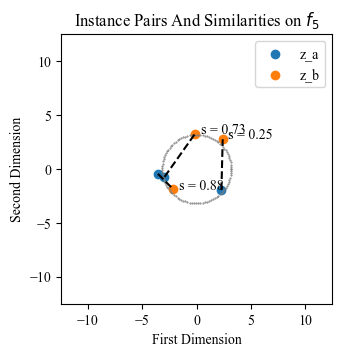

In [113]:
# Set up the raw manifold function
manifold_name = 'f_6'
manifold_function = lambda S: ((2*s_max/(2*np.pi))*np.cos((S+s_max)*(2*np.pi)/(2*s_max)), (2*s_max/(2*np.pi))* np.sin((S+s_max)*(2*np.pi)/(2*s_max)))

# Generate a dataset
reset_random_number_generators(seed=934) # Reproducability
noise_strength = 0.5
Z, Y = create_data_set(S=S, manifold_function=manifold_function, noise_strength=noise_strength) # Z.shape == [M, N], Y.shape = [M, F]

# Plot pairs of instances
iterator = mdis.volatile_factorized_pair_iterator(X=Z, Y=Y, batch_size=32, similarity_function=similarity_function)
Z_ab, Y_ab = next(iterator)

plot_instance_pairs(S=S_star, Z_ab=Z_ab[:3,:,:], Y_ab=Y_ab[:3,:], manifold_function=manifold_function, manifold_name=manifold_name)

### Model Calibration

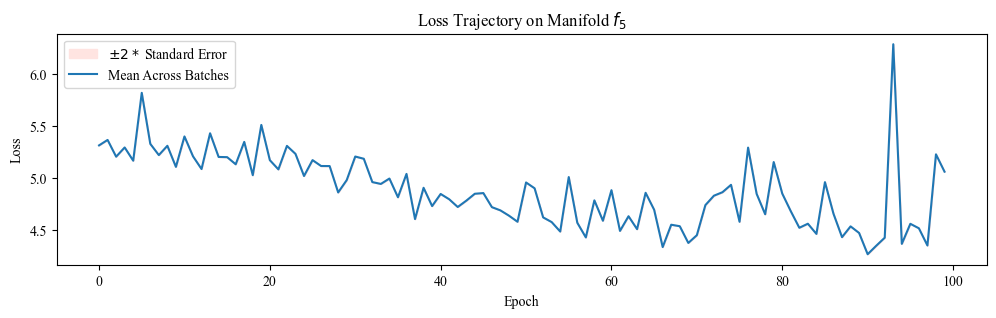

In [122]:
# Create network
reset_random_number_generators(seed=594) # Reproducability
network = create_network(Z_sample=Z[np.random.choice(M, size=128)], stage_count=3)
network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))

# Calibrate network
batch_size = 1024
iterator = mdis.volatile_factorized_pair_iterator(X=Z, Y=Y, batch_size=batch_size, similarity_function=similarity_function)
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=500, batch_count=M//batch_size)
plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

In [ ]:
# Cross validate model behaviour
reset_random_number_generators(seed=620) # Reproducability
networks = [None] * 5 # Fold-count many networks
for i in range(len(networks)):
    networks[i] = create_network(Z_sample=Z[np.random.choice(M, size=128)], stage_count=3)
    networks[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))
Z_test, Y_test = cross_validate(Z=Z, Y=Y, networks=networks, batch_size=512, epoch_count=500, similarity_function=similarity_function, manifold_name=manifold_name)

### Evaluation

In [ ]:
# Plot input and output
plot_input_output(network, S_range = [np.min(S), np.max(S)], manifold_function=manifold_function, noise_strength=noise_strength, manifold_name=manifold_name)

# Plot interactive tool
interact(plot_inverse_point, position=(-1.5,1.5,0.1), residual=(-1.5,1.5,0.1), S=fixed(S_star), network=fixed(network), manifold_function=fixed(manifold_function), manifold_name=fixed(manifold_name))

# Plot cross validation
evaluate_and_plot_networks(Z_test=Z_test, Y_test=Y_test, networks=networks, manifold_name=manifold_name)